In [36]:
import jax
import jax.numpy as jnp

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns  

import liesel.model as lsl
import liesel.goose as gs

import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.jax.bijectors as tfb

from tensorflow_probability.substrates.jax.experimental import distributions as tfde
from tensorflow_probability.python.internal.backend.jax.compat import v2 as tf

from functools import partial

In [37]:
# --- 1. Bulletproof Factory Functions ---

def make_wishart(df, scale_tril):
    """Factory that keeps validate_args strictly as a Python constant."""
    return tfd.WishartTriL(
        df=df, 
        scale_tril=scale_tril, 
        input_output_cholesky=True, 
        validate_args=False
    )

def make_mvn_precision(loc, precision_factor):
    """Factory for Precision-based MVN."""
    return tfde.MultivariateNormalPrecisionFactorLinearOperator(
        loc=loc,
        precision_factor=tf.linalg.LinearOperatorLowerTriangular(precision_factor),
        validate_args=False
    )

In [38]:
# --- 2. Data Simulation ---

def simulate_data(seed=42):
    key = jax.random.PRNGKey(seed)
    k1, k2, k3 = jax.random.split(key, 3)
    
    n_units, n_obs_small, n_obs_large, n_alts, n_params = 100, 5, 50, 5, 5
    counts = jnp.array([n_obs_small] * 50 + [n_obs_large] * 50)
    unit_idx = jnp.repeat(jnp.arange(n_units), counts)
    
    true_mu = jnp.array([1.0, -1.0, 0.0, 0.0, -3.0])
    true_Sigma = 3.0 * jnp.eye(n_params)
    true_Sigma = true_Sigma.at[3, 4].set(1.5)
    true_Sigma = true_Sigma.at[4, 3].set(1.5)
    
    beta_dist = tfd.MultivariateNormalFullCovariance(loc=true_mu, covariance_matrix=true_Sigma)
    betas = beta_dist.sample(seed=k1, sample_shape=(n_units,))
    
    X_list, y_list = [], []
    for i in range(n_units):
        n_i, beta_i = counts[i], betas[i]
        k2, sk = jax.random.split(k2)
        price = jax.random.uniform(sk, shape=(n_i, n_alts), minval=-1.5, maxval=0.0)
        
        D = jnp.zeros((n_i, n_alts, n_params))
        for a in range(4): D = D.at[:, a, a].set(1.0)
        D = D.at[:, :, 4].set(price)
        
        logits = jnp.einsum('ijk,k->ij', D, beta_i)
        k3, sk = jax.random.split(k3)
        choices = tfd.Categorical(logits=logits).sample(seed=sk)
        
        X_list.append(D)
        y_list.append(choices)
        
    return {
        "X": jnp.concatenate(X_list, axis=0),
        "y": jnp.concatenate(y_list, axis=0),
        "betas": betas,
        "unit_idx": unit_idx,
        "true_mu": true_mu,
        "true_Sigma": true_Sigma
    }

data = simulate_data()
k_dim = 5
n_units = 100

In [39]:
# --- 3. Model Building (Cleaned) ---

# Constants (Raw values to prevent tracer issues during setup)
nu_val = float(k_dim + 3)
V_inv_val = jnp.linalg.inv(nu_val * jnp.eye(k_dim))
Vinv_chol_val = jnp.linalg.cholesky(V_inv_val)
A_val = 0.01
zero_loc_val = jnp.zeros(k_dim)

# 1. Precision Matrix Cholesky Factor
# We use the factory function here
sigma_inv_chol = lsl.Var.new_param(
    value=jnp.eye(k_dim),
    distribution=lsl.Dist(make_wishart, df=nu_val, scale_tril=Vinv_chol_val),
    name="sigma_inv_chol"
)

# 2. Transformation
# Liesel will now re-run 'make_wishart' internally without hitting tracer errors
sigma_inv_chol_latent = sigma_inv_chol.transform(
    tfb.FillScaleTriL(), 
    name="sigma_inv_chol_latent"
)

# 3. Population Mean (mu)
mu_prec_factor = lsl.Var.new_calc(
    lambda L: jnp.sqrt(A_val) * L, 
    L=sigma_inv_chol, 
    name="mu_prec_factor"
)

mu = lsl.Var.new_param(
    value=jnp.zeros(k_dim),
    distribution=lsl.Dist(make_mvn_precision, loc=zero_loc_val, precision_factor=mu_prec_factor),
    name="mu"
)

# 4. Unit-Level Parameters (beta_i)
beta_i = lsl.Var.new_param(
    value=jnp.zeros((n_units, k_dim)),
    distribution=lsl.Dist(make_mvn_precision, loc=mu, precision_factor=sigma_inv_chol),
    name="beta_i"
)

# --- 4. Likelihood ---

X_var = lsl.Var.new_obs(data["X"], name="X_obs")
idx_var = lsl.Var.new_obs(data["unit_idx"], name="idx_obs")

# Expanded beta: mapping 100 unit-betas to the observations
beta_expanded = lsl.Var.new_calc(
    lambda b, idx: b[idx], 
    b=beta_i, 
    idx=idx_var, 
    name="beta_expanded"
)

# Utility/Logits calculation
logits = lsl.Var.new_calc(
    lambda x, b: jnp.einsum("nij,nj->ni", x, b), 
    x=X_var, 
    b=beta_expanded, 
    name="logits"
)

# Final Likelihood
y_var = lsl.Var.new_obs(
    data["y"], 
    distribution=lsl.Dist(tfd.Categorical, logits=logits), 
    name="y"
)

In [40]:
# --- 5. Model Assembly ---
model = lsl.Model([y_var])

eb = gs.EngineBuilder(seed=123, num_chains=4)
eb.set_model(gs.LieselInterface(model))
eb.set_initial_values(model.state)

# Kernels
eb.add_kernel(gs.NUTSKernel(["mu"]))
eb.add_kernel(gs.NUTSKernel(["sigma_inv_chol_latent"], mm_diag=False))
eb.add_kernel(gs.NUTSKernel(["beta_i"]))

eb.set_duration(warmup_duration=1000, posterior_duration=10000)

engine = eb.build()
engine.sample_all_epochs()

c:\Users\ThinkPad\Desktop\Repositories\BDCM\liesel_project\.venv\Lib\site-packages\jax\_src\numpy\array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
liesel.goose.builder - WARNING - No jitter functions provided. The initial values won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together
100%|██████████████████████████████████████████| 3/3 [00:18<00:00,  6.24s/chunk]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 4, 2, 3, 4 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for ke

## Model Diagnostics

In [41]:
# Extract Results
results = engine.get_results()
samples = results.get_posterior_samples()

# Create summary for numerical diagnostics 
summary = gs.Summary(results)
# display(summary)
# (R-hat < 1.05 indicates convergence)

In [42]:
def plot_detailed_param(results_dict, param_name, param_indices):
    """
    Plot detailed diagnostics for a parameter.
    param_indices can be a single int or list of ints.
    """
    if isinstance(param_indices, int):
        param_indices = [param_indices]
    for idx in param_indices:
        print(f"Detailed Diagnostics: {param_name}[{idx}]")
        gs.plot_param(results_dict, param_name, param_index=idx)
        plt.show()


 Global Mu Trace Plots


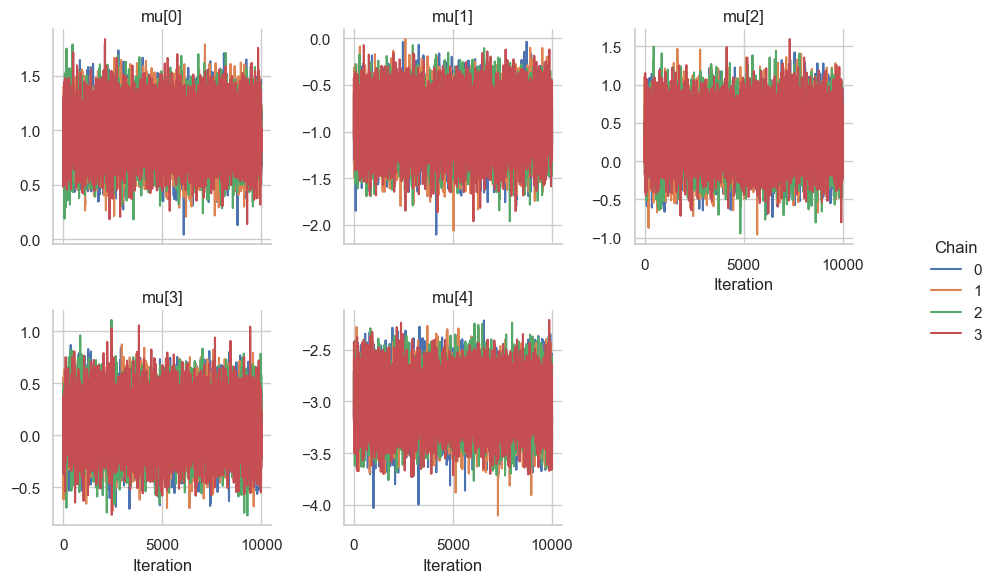


Detailed Mu Parameter Diagnostics
Detailed Diagnostics: mu[0]


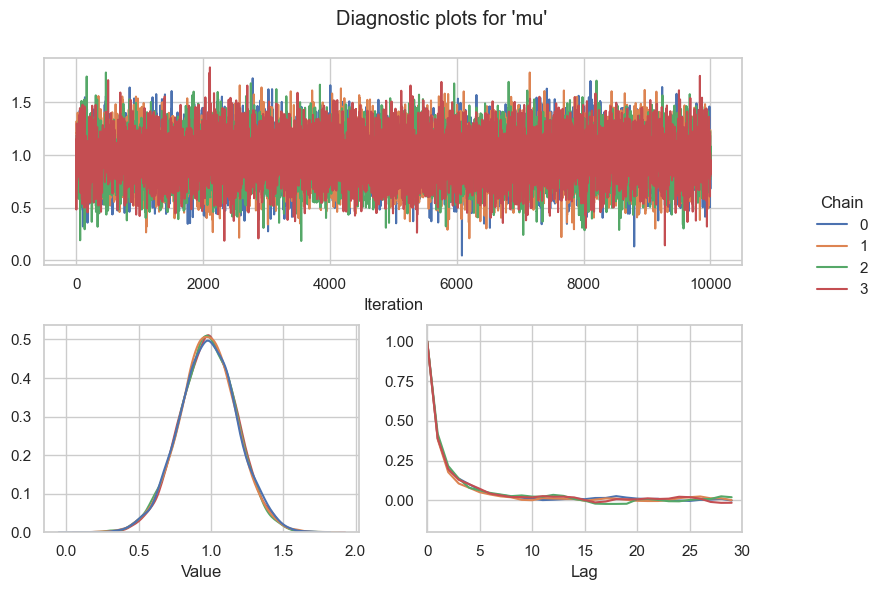

Detailed Diagnostics: mu[1]


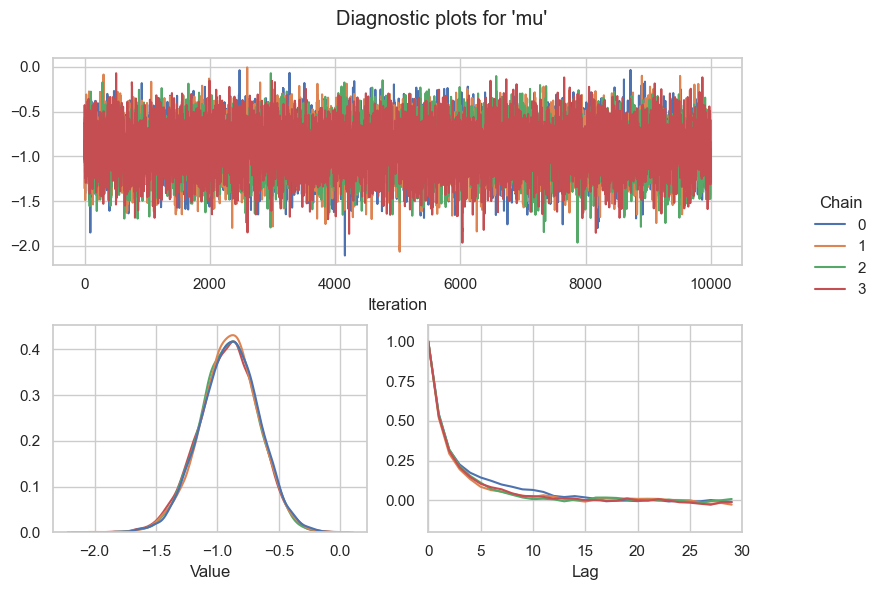

Detailed Diagnostics: mu[2]


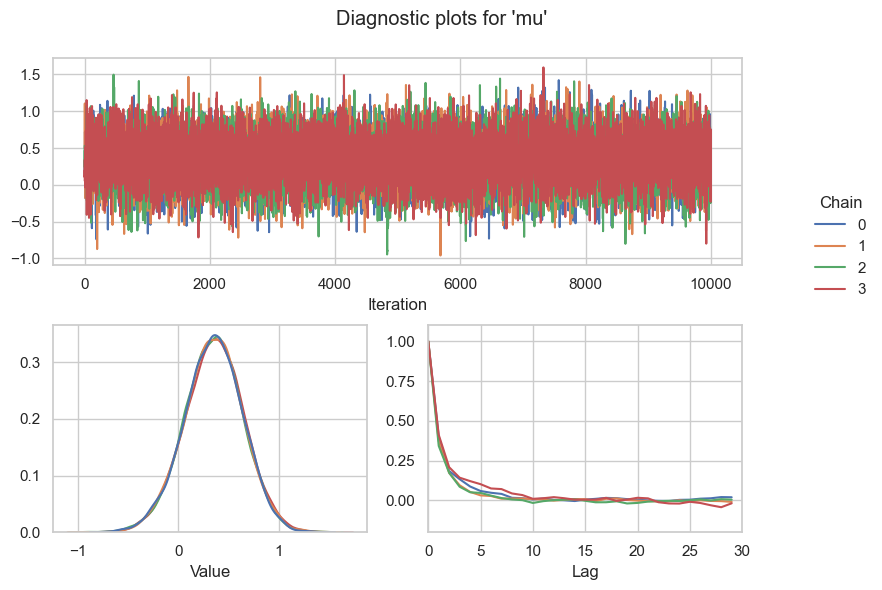

Detailed Diagnostics: mu[3]


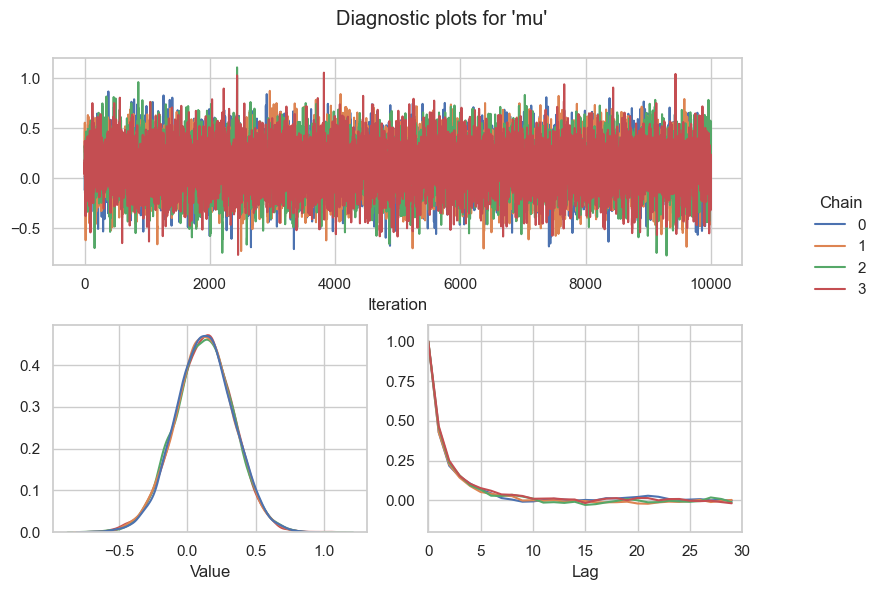

Detailed Diagnostics: mu[4]


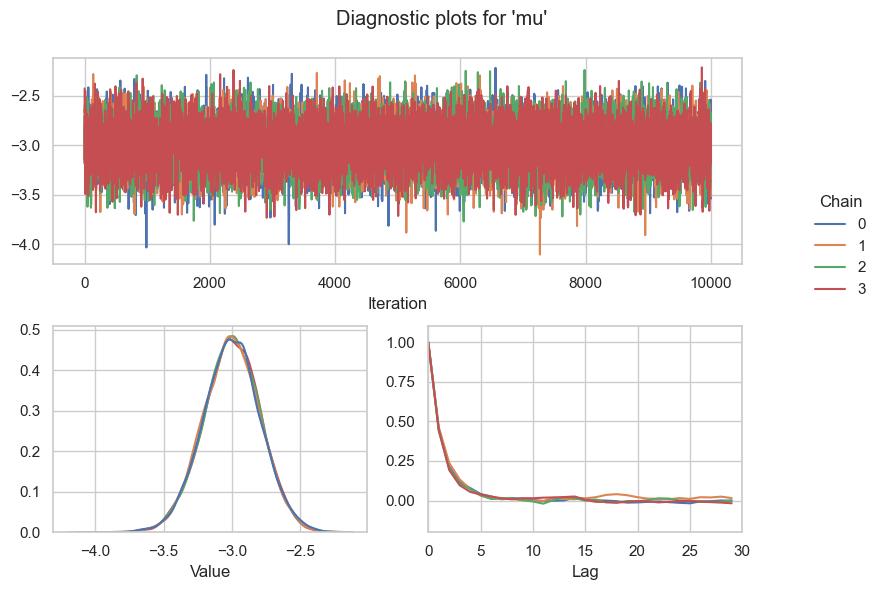

In [43]:
# =======================
# CONVERGENCE DIAGNOSTICS
# =======================

# Global mu Diagnostics
print("\n Global Mu Trace Plots")
gs.plot_trace(results, "mu")
plt.show()

print("\nDetailed Mu Parameter Diagnostics")
plot_detailed_param(results, "mu", param_indices=range(5))
plt.show()

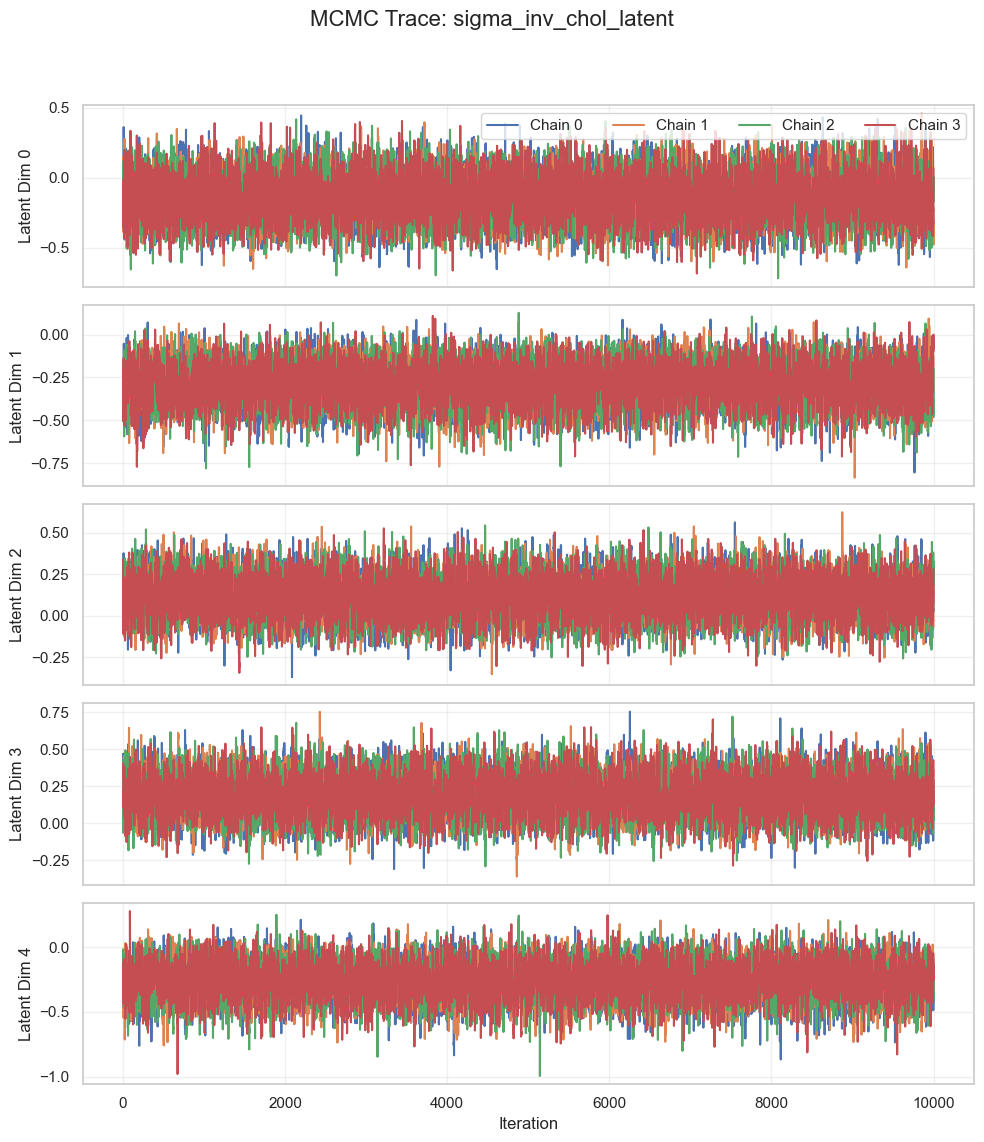

In [44]:
# 1. Get the latent samples
# Shape: (chains, draws, 15)
latent_samples = results.get_posterior_samples()["sigma_inv_chol_latent"]
n_chains, n_draws, n_latent = latent_samples.shape

# 2. Plot trace for a subset of the 15 latent parameters
# Plotting 5 elements for readability
fig, axes = plt.subplots(5, 1, figsize=(10, 12), sharex=True)

for i in range(5):
    for chain in range(n_chains):
        axes[i].plot(latent_samples[chain, :, i], alpha=1, label=f"Chain {chain}")
    axes[i].set_ylabel(f"Latent Dim {i}")
    axes[i].grid(True, alpha=0.3)

axes[0].legend(loc="upper right", ncol=n_chains)
axes[-1].set_xlabel("Iteration")
plt.suptitle("MCMC Trace: sigma_inv_chol_latent", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# 1. Setup the bijector (must match the one in your model)
bijector = tfb.FillScaleTriL()

# 2. Function to turn 1D vector -> 5x5 Matrix -> Covariance Matrix
def latent_to_sigma(latent_vec):
    # Step A: Map 15-dim vector to 5x5 Lower Triangular Matrix (L)
    L = bijector.forward(latent_vec)
    
    # Step B: Compute Precision (Omega = L @ L.T)
    # Step C: Invert to get Covariance (Sigma = inv(Omega))
    # This is equivalent to inv(L.T) @ inv(L) which is more stable
    precision_mat = L @ L.T
    return jnp.linalg.inv(precision_mat)

# 3. Vectorize across chains and draws
v_latent_to_sigma = jax.vmap(jax.vmap(latent_to_sigma))
sigma_samples = v_latent_to_sigma(latent_samples)

# 4. Final Comparison
sigma_posterior_mean = jnp.mean(sigma_samples, axis=(0, 1))

print("--- Comparison of Covariance Matrices ---")
print("\nTrue Sigma (Simulation):")
print(jnp.round(data["true_Sigma"], 3))

print("\nEstimated Sigma (Posterior Mean):")
print(jnp.round(sigma_posterior_mean, 3))

--- Comparison of Covariance Matrices ---

True Sigma (Simulation):
[[3.0000002 0.        0.        0.        0.       ]
 [0.        3.0000002 0.        0.        0.       ]
 [0.        0.        3.0000002 0.        0.       ]
 [0.        0.        0.        3.0000002 1.5000001]
 [0.        0.        0.        1.5000001 3.0000002]]

Estimated Sigma (Posterior Mean):
[[ 2.423       0.24200001  0.36200002 -0.05        0.57100004]
 [ 0.24200001  2.515       0.77900004 -0.025      -0.63500005]
 [ 0.36200002  0.77900004  5.5620003  -0.12400001 -0.62200004]
 [-0.05       -0.025      -0.12400001  2.611       1.049     ]
 [ 0.57100004 -0.63500005 -0.62200004  1.049       2.608     ]]


In [46]:
# Extract samples for the covariance of interest [3, 4]
cov_34_samples = sigma_samples[:, :, 3, 4].flatten()

# Calculate Credible Interval
ci_low, ci_high = jnp.quantile(cov_34_samples, jnp.array([0.025, 0.975]))

print(f"Covariance [3,4]:")
print(f"  True Value: 1.500")
print(f"  Posterior Mean: {jnp.mean(cov_34_samples):.3f}")
print(f"  95% Credible Interval: [{ci_low:.3f}, {ci_high:.3f}]")

Covariance [3,4]:
  True Value: 1.500
  Posterior Mean: 1.049
  95% Credible Interval: [0.290, 1.990]
